In [1]:
import sys
from pathlib import Path
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
import matplotlib.pyplot as plt
import json

# Set ROOT path to access other directories in project
ROOT = Path.cwd().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import SnowDepth.data_loader as DL
import SnowDepth.data_splitter as DS
import SnowDepth.architecture as ARCH
import SnowDepth.visualization as VIZ
import SnowDepth.evaluation as EVAL
import SnowDepth.feature_filtering as FF
import SnowDepth.optimal_features as OF

In [2]:
# Assign seed
seed = 18

# Path to TIFF files
data_dir = ROOT/"data"/"tif_files"

# Select holdout AOI
holdout_aoi="ID_BS"

# Select amount of features to select from FF algos
top_k = 10

# Load dataframe
df = DL.build_df(str(data_dir), drop_invalid=True, upper_threshold=3)

dev_df  = df[df['aoi_name'] != holdout_aoi].copy()
hold_df = df[df['aoi_name'] == holdout_aoi].copy()

In [3]:
ff_algos = OF.optimal_feature_sets(dev_df, top_k=10, n_per_aoi=10000)

Block HSIC Lasso B = 20.
M set to 3.
Using Gaussian kernel for the features, Gaussian kernel for the outcomes.
HSIC (top 10): ['IAFE', 'Gamma_VH_RTC', 'cos_Aspect', 'Gamma_VV_RTC', 'Beta_ratio', 'Slope', 'LIA', 'Gamma_RTC_ratio', 'Beta_VH', 'sin_Aspect']
PCC  (top 10): ['IAFE', 'cos_Aspect', 'Gamma_VH_RTC', 'Gamma_VV_RTC', 'Elevation', 'Beta_VH', 'Slope', 'LIA']
MI   (top 10): ['IAFE', 'Elevation', 'Gamma_VH_RTC', 'Gamma_VV_RTC', 'Gamma_RTC_sum', 'cos_Aspect', 'Beta_VH', 'Slope', 'Gamma_ratio']


In [ ]:
if not Path("optimal_features.json").exists():
    OF.optimal_feature_sets_json(
        data_dir=data_dir,
        holdout_aoi=holdout_aoi,
        top_k=top_k,
        upper_threshold=3,
        out_json="optimal_features.json"
    )

with open("optimal_features.json", "r", encoding="utf-8") as f:
    obj = json.load(f)

HSIC_FEATURES  = obj["sets"]["HSIC"]
PCC_FEATURES = obj["sets"]["PCC"]

# Example:
X_HSIC = dev_df[HSIC_FEATURES].to_numpy()
y = dev_df["SD"].to_numpy()

NameError: name 'optimal_feature_sets_json' is not defined

In [4]:
X_dev, y_dev, groups, X_hold, y_hold = DS.RF_split(
    dev_df=dev_df,
    hold_df=hold_df,
    seed=seed,
    pxs_per_aoi=10000
)

Total samples: 40000 across 4 AOIs
Features used: ['VH_dB', 'VV_dB', 'CrossPolRatio_dB', 'Elevation', 'Slope', 'sin_Aspect', 'cos_Aspect']
X_dev shape: (40000, 7)
X_hold shape: (1655811, 7)


Train RF and tune hyperparameters

In [5]:
rf = RandomForestRegressor(random_state=seed)

param_grid = {
    "max_features": [1],
    "min_samples_leaf":  [30],
    "n_estimators": [300]
    #"max_depth": [None],
    #"min_samples_split": [2],
}

logo = LeaveOneGroupOut()

grid = GridSearchCV(
    estimator  = rf,
    param_grid = param_grid,
    cv         = logo,
    scoring    = 'neg_root_mean_squared_error',
    n_jobs     = -1,
    verbose    = 2
)

# Run grid search with group labels 
grid.fit(X_dev, y_dev, groups=groups)

print("Best hyperparameters:", grid.best_params_)
print("Best CV RMSE: ", np.sqrt(-grid.best_score_))

# Final training & evaluation on hold-out AOI
best_rf = grid.best_estimator_

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Best hyperparameters: {'max_features': 1, 'min_samples_leaf': 30, 'n_estimators': 300}
Best CV RMSE:  0.8206987538005429


In [6]:
# Predict and calculate performance metrics
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


y_hold_pred = best_rf.predict(X_hold)
rmse_hold = root_mean_squared_error(y_hold, y_hold_pred)
mae_hold  = mean_absolute_error(y_hold, y_hold_pred)

print(f"Hold-out RMSE = {rmse_hold:.7f}")
print(f"Hold-out MAE  = {mae_hold:.7f}")

# Add predictions to Dataframe for visualization later
hold_df["SD_pred"] = y_hold_pred

Hold-out RMSE = 0.4050210
Hold-out MAE  = 0.3256187


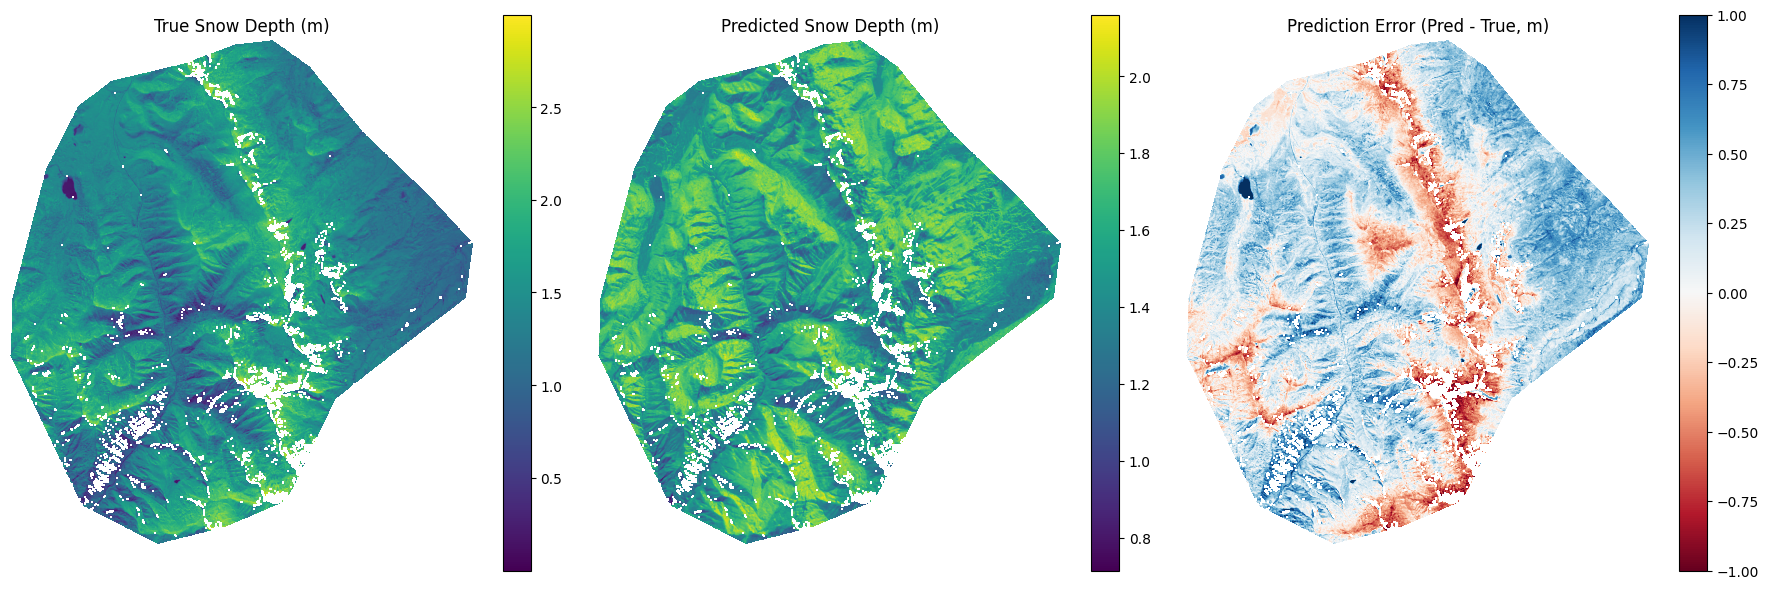

In [7]:
# Get shape of the raster
n_rows = hold_df['row'].max() + 1
n_cols = hold_df['col'].max() + 1

# Create empty arrays and fill them with NaNs
true_map  = np.full((n_rows, n_cols), np.nan)
pred_map  = np.full((n_rows, n_cols), np.nan)
error_map = np.full((n_rows, n_cols), np.nan)

# Fill valid values using row/col
rows = hold_df['row'].values
cols = hold_df['col'].values
true_map[rows, cols]  = hold_df['SD'].values.flatten()
pred_map[rows, cols]  = hold_df['SD_pred'].values.flatten()
error_map[rows, cols] = (hold_df['SD_pred'].values - hold_df['SD'].values).flatten()

# Plot all maps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

im0 = axs[0].imshow(true_map, cmap='viridis')
axs[0].set_title("True Snow Depth (m)")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(pred_map, cmap='viridis')
axs[1].set_title("Predicted Snow Depth (m)")
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(error_map, cmap='RdBu', vmin=-1, vmax=1)
axs[2].set_title("Prediction Error (Pred - True, m)")
plt.colorbar(im2, ax=axs[2])

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()